# Backpropagation in Multilayer Neural Networks

### Goals: 
- Diving deep: implement a real gradient descent in `Numpy`

### Dataset:
- Similar as first Lab - Digits: 10 class handwritten digits
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()

In [2]:
print(len(digits.images))

1797


(8, 8)


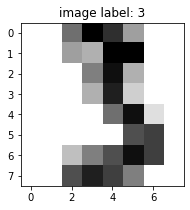

In [3]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index])
print(digits.images[45].shape)

### Preprocessing

- Normalization
- Train / test split

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
#print(scaler.scale_)

[0.00000000e+00 2.98624754e-01 5.19253438e+00 1.18428291e+01
 1.18565815e+01 5.81008513e+00 1.34774067e+00 1.19187950e-01
 6.54878847e-03 1.99345121e+00 1.03464309e+01 1.19305828e+01
 1.02626064e+01 8.20497708e+00 1.84348396e+00 9.88867060e-02
 3.27439424e-03 2.61624100e+00 9.83497053e+00 6.87098887e+00
 7.11263916e+00 7.83759005e+00 1.75376555e+00 4.45317616e-02
 1.30975769e-03 2.48788474e+00 9.04453176e+00 8.73280943e+00
 9.98231827e+00 7.57105435e+00 2.26850033e+00 2.61951539e-03
 0.00000000e+00 2.36149312e+00 7.68369352e+00 9.07924034e+00
 1.03713163e+01 8.79240341e+00 2.89980354e+00 0.00000000e+00
 8.51342502e-03 1.57039948e+00 6.84937787e+00 7.22855272e+00
 7.65029470e+00 8.26522593e+00 3.48592010e+00 2.61951539e-02
 8.51342502e-03 6.83693517e-01 7.49312377e+00 9.56516045e+00
 9.36869679e+00 8.77668631e+00 3.76686313e+00 2.08906352e-01
 6.54878847e-04 2.78978389e-01 5.53700065e+00 1.20595940e+01
 1.17832351e+01 6.81990832e+00 2.07465619e+00 3.42501637e-01]


In [ ]:
X_train.shape

In [ ]:
X_train.dtype

In [ ]:
X_test.shape

In [ ]:
y_train.shape

In [ ]:
y_train.dtype

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [5]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [6]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [7]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [8]:
def softmax(X):
    # TODO:
    temp = np.exp(X)/np.sum(np.exp(X))
    return temp

Make sure that this works one vector at a time (and check that the components sum to one):

In [9]:
print(softmax([10, 2, -3]))
temp1 = softmax([10, 2, -3])
print(np.sum(temp1))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]
1.0


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [10]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))
print(np.sum(softmax(X)))

[[9.92957576e-01 3.33100158e-04 2.24441121e-06]
 [1.65840803e-05 6.69049552e-03 9.29172262e-14]]
1.0


Here is a way to implement softmax that works both for an individual vector of activations and for a batch of activation vectors at once:

In [11]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Probabilities should sum to 1:

In [12]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [13]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [14]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [15]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    #Y_true = softmax(Y_true)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    
    # TODO
    l = -np.sum(Y_true* np.log(Y_pred)+ (1 - Y_true) * np.log(1 - Y_pred))
    # print(f"{l}")
    return l


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.0201006717070039


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [16]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

8.527243527269738


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [17]:
def nll(Y_true, Y_pred):
    N = Y_true.shape[0]
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)

    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    
    # TODO
    l = -np.mean(Y_true* np.log(Y_pred)+ (1 - Y_true) * np.log(1 - Y_pred))
    #print(f"{l}")
    return l

In [18]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

Y_true = np.array([[0, 0, 1],
                   [0, 0, 1],
                   [1, 0, 0]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.002233407967445544
19.701189076806155


Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [19]:
class Item:
  def calculate_total_price(self):
    print(self.name)
    return self.price*self.quantity
  
item1 = Item()
item1.name = 'phone'
item1.price = 10
item1.quantity = 10
print(item1.calculate_total_price())

item2 = Item()
item2.name = 'laptop'
item2.price = 100
item2.quantity = 2
print(item2.calculate_total_price())




# def calculate_total_price(ItemPrice, ItemQuantity):
#   return ItemPrice*ItemQuantity
  
# x = 10
# y = 10
# print(calculate_total_price(x, y))


phone
100
laptop
200


In [20]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

def nll(Y_true, Y_pred):
    N = Y_true.shape[0]
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)

    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    
    # TODO
    l = -np.mean(Y_true* np.log(Y_pred)+ (1 - Y_true) * np.log(1 - Y_pred))
    #print(f"{l}")
    return l

class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X): 
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b} 
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"] 
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, x, y):
        return nll(one_hot(self.output_size, y), self.forward(x)) 

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)
        

In [21]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 0.3364, train acc: 0.058, test acc: 0.059


Evaluate the randomly initialized model on the first example:

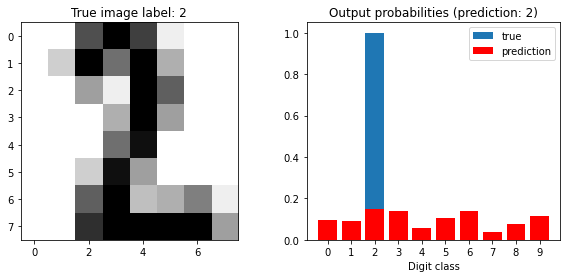

In [22]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx].reshape(1, -1)).reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')

    ax0.set_title("True image label: %d" % y_test[sample_idx]);

    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

In [23]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 0.3332, train acc: 0.086, test acc: 0.107
Update #100, train loss: 0.2076, train acc: 0.721, test acc: 0.715
Update #200, train loss: 0.1456, train acc: 0.842, test acc: 0.848
Update #300, train loss: 0.1112, train acc: 0.889, test acc: 0.881
Update #400, train loss: 0.0937, train acc: 0.899, test acc: 0.911
Update #500, train loss: 0.0819, train acc: 0.910, test acc: 0.933
Update #600, train loss: 0.0726, train acc: 0.923, test acc: 0.930
Update #700, train loss: 0.0660, train acc: 0.930, test acc: 0.944
Update #800, train loss: 0.0623, train acc: 0.931, test acc: 0.941
Update #900, train loss: 0.0580, train acc: 0.938, test acc: 0.948
Update #1000, train loss: 0.0545, train acc: 0.938, test acc: 0.948
Update #1100, train loss: 0.0512, train acc: 0.946, test acc: 0.959
Update #1200, train loss: 0.0488, train acc: 0.948, test acc: 0.967
Update #1300, train loss: 0.0466, train acc: 0.946, test acc: 0.956
Update #1400, train loss: 0.0447, train acc: 0.951, test acc

Evaluate the trained model on the first example:

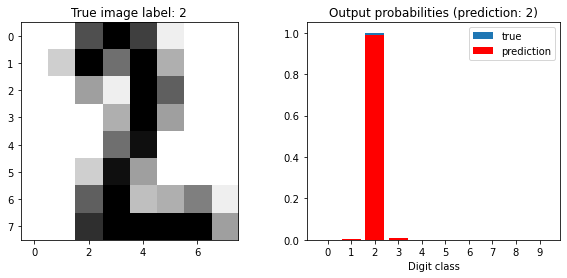

In [24]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

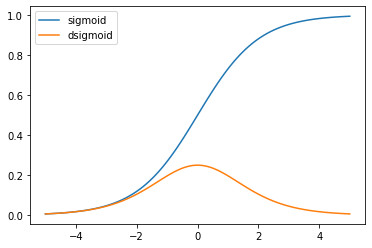

In [25]:
def sigmoid(X):
    # TODO
    temp = 1/(1 + np.exp(-x))
    return temp

def dsigmoid(X):
    # TODO
    # temp = 1/(1 + np.exp(-x))
    # temp = temp*(1-temp)
    temp = sigmoid(X)*(1-sigmoid(X))
    return temp


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

**Bonus**: reimplementing all from scratch only using the lecture slides but without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [26]:
EPSILON = 1e-8

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dsigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

def nll(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + EPSILON), axis=1))

class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size
        
    def forward(self, X):
        # TODO
        h = sigmoid(np.dot(X, self.W_h) + self.b_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y
    
    def forward_keep_activations(self, X):
        # TODO
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h
        
    def loss(self, X, y):
        # TODO
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        # TODO
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - one_hot(self.output_size, y_true)
        grad_W_o = np.dot(h.T, grad_z_o)
        grad_b_o = np.sum(grad_z_o, axis=0)
        grad_h = np.dot(grad_z_o, self.W_o.T)
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.dot(x.T, grad_z_h)
        grad_b_h = np.sum(grad_z_h, axis=0)
        grads = {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
        return grads
    
    def train(self, x, y, learning_rate=0.1):
        # TODO
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x.reshape(1, -1), y)
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        output = self.forward(X)
        if output.ndim == 1:  # Ensure output is 2D for argmax
            output = output.reshape(1, -1)
        return np.argmax(output, axis=1)


    def accuracy(self, X, y):
        y_preds = self.predict(X)
        return np.mean(y_preds == y)

### getting data again to ensure that everything is up-to-date

In [27]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
#print(scaler.scale_)

In [28]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = int(np.sqrt(n_features*n_classes))
print("n_hidden is", n_hidden)
nn = NeuralNet(n_features, n_hidden, n_classes)

print("Evaluation of the untrained model:")
train_loss = nn.loss(X_train, y_train)
train_acc = nn.accuracy(X_train, y_train)
test_acc = nn.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

n_hidden is 25
Evaluation of the untrained model:
train loss: 2.3028, train acc: 0.102, test acc: 0.089


In [ ]:
# n_hidden = 10
# model = NeuralNet(n_features, n_hidden, n_classes)

In [ ]:
# model.loss(X_train, y_train)

In [ ]:
# model.accuracy(X_train, y_train)

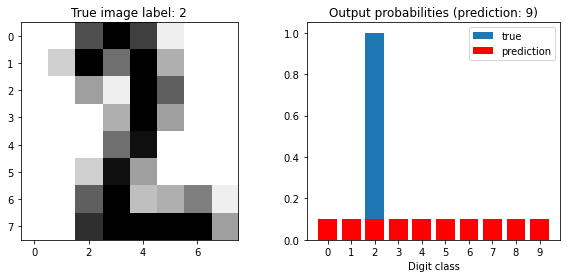

In [29]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx].reshape(1, -1)).reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')

    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(nn, sample_idx=0)

## Now we train the network!

In [30]:
losses, accuracies, accuracies_test = [], [], []
losses.append(nn.loss(X_train, y_train))
accuracies.append(nn.accuracy(X_train, y_train))
accuracies_test.append(nn.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f" % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        nn.train(x, y, 0.1)
        
    losses.append(nn.loss(X_train, y_train))
    accuracies.append(nn.accuracy(X_train, y_train))
    accuracies_test.append(nn.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f" % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.30282, train acc: 0.102, test acc: 0.089
Epoch #1, train loss: 0.23107, train acc: 0.938, test acc: 0.915
Epoch #2, train loss: 0.11546, train acc: 0.970, test acc: 0.941
Epoch #3, train loss: 0.06554, train acc: 0.988, test acc: 0.959
Epoch #4, train loss: 0.04345, train acc: 0.994, test acc: 0.959
Epoch #5, train loss: 0.03250, train acc: 0.997, test acc: 0.967
Epoch #6, train loss: 0.02575, train acc: 0.999, test acc: 0.967
Epoch #7, train loss: 0.02071, train acc: 0.999, test acc: 0.963
Epoch #8, train loss: 0.01672, train acc: 0.999, test acc: 0.967
Epoch #9, train loss: 0.01372, train acc: 0.999, test acc: 0.967
Epoch #10, train loss: 0.01169, train acc: 1.000, test acc: 0.967
Epoch #11, train loss: 0.01013, train acc: 1.000, test acc: 0.970
Epoch #12, train loss: 0.00880, train acc: 1.000, test acc: 0.970
Epoch #13, train loss: 0.00800, train acc: 1.000, test acc: 0.978
Epoch #14, train loss: 0.00722, train acc: 1.000, test acc: 0.978
Epoch #15, train 

Text(0.5, 1.0, 'Training loss')

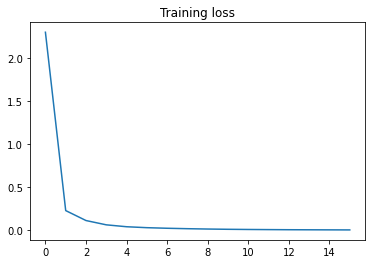

In [31]:
plt.plot(losses)
plt.title("Training loss")

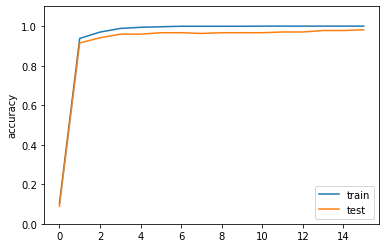

In [32]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best')

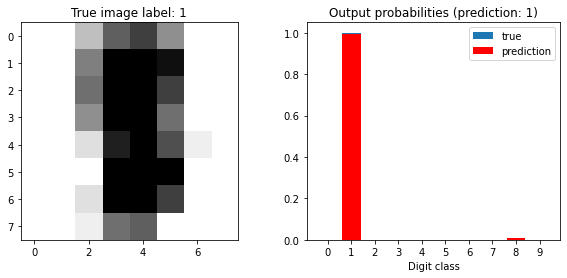

In [33]:
plot_prediction(nn, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum



## Homework assignments

- Watch the following video on [how to code a minimal deep learning framework](https://www.youtube.com/watch?v=o64FV-ez6Gw)

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("o64FV-ez6Gw")

- **Optional**: read the following blog post on Reverse-Mode Automatic Differentiation from start to section "A simple implementation in Python" included:

  https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation